# ![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Toy Example CPG Tutorial</center></h1>


This notebook provides an introductory tutorial for the usage of Central Pattern Generators (CPG) for robotic locomotion.
Specifically, we cover the bio-inspired origin of CPGs and how they can be implemented using differential equations. Furthermore, we show how these differential equations can be solved numerically using Jax.
Afterwards, we apply a CPG to an environment of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb). BRB provides a collection of bio-inspired robotics environments implemented in MuJoCo and MuJoCo XLA (MJX).

In [76]:
import functools
from collections import namedtuple

import jax
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Tuple
import jax.numpy as jnp
from flax import struct

## CPG intro

* Bio-inspiration
* Two approaches
    * Connectionist
    * Differential equations

## Numerically solving differential equations

* Why numerically

### Example problem
* Solving differential equations lies at the root of physics simulators
* Physical phenomena are often more easily and accurately described via differential equations (e.g. when describing how forces influence the system's dynamics) 
* At a certain point in time, we have positions, velocities and accelerations
    * We want to calculate the values for the next step -> we need to solve the differential equations that describe their transition
    * position p, velocity v, acceleration a
    * p' = v
    * v' = a
* Example
    * First order ODE
        * Imagine we want to simulate the 1D trajecory for a point p(t)
        * We know how its velocity changes over time, i.e. we're given this as a function v(t)
        * How can get p(t) from v(t) and some initial conditions (v(0) and p(0))? -> we solve the differential equation p' = v(t,p) or y' = f(t, y)

Lets first create a function that will allow us to visualize the outcome trajectory.

In [77]:
def visualise_trajectory(
        times: np.ndarray,
        positions: np.ndarray
        ) -> None:
    plt.plot(times, positions)
    plt.xlabel("time")
    plt.ylabel("position")
    plt.show()
    plt.close()

The ODE is p' = v(t,p) or y' = f(t, y)
We can get the next position by taking a small step in the direction of the velocity

In [78]:
def velocity(
        time: float,
        position: float
        ) -> float:
    return np.sin(time)


def get_next_position(
        current_time: float,
        current_position: float,
        velocity_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    # take a small step
    current_velocity = velocity_fn(current_time, current_position)
    return current_position + current_velocity * delta_time

Solving the ODE

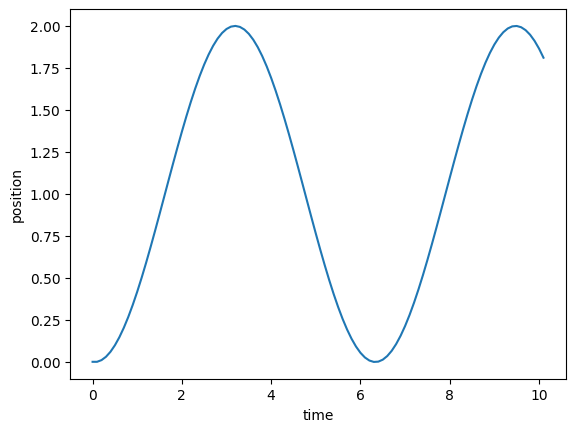

In [79]:
times = [0]
positions = [0]
delta_time = 0.1

while times[-1] < 10:
    new_position = get_next_position(
            current_time=times[-1], current_position=positions[-1], velocity_fn=velocity, delta_time=delta_time
            )
    times.append(times[-1] + delta_time)
    positions.append(new_position)

visualise_trajectory(times=times, positions=positions)

### Euler
Taking a small step in the direction of the derivative of the function, which allows us to calculate the slope at a certain point, is exactly what the Euler method does.
We can thus generalize our previous approach and write the following euler solver:

In [80]:
def euler(
        current_time: float,
        current_y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, current_y)
    next_y = current_y + slope * delta_time
    return next_y

Our previous trajectory retriever can thus be implemented like this:

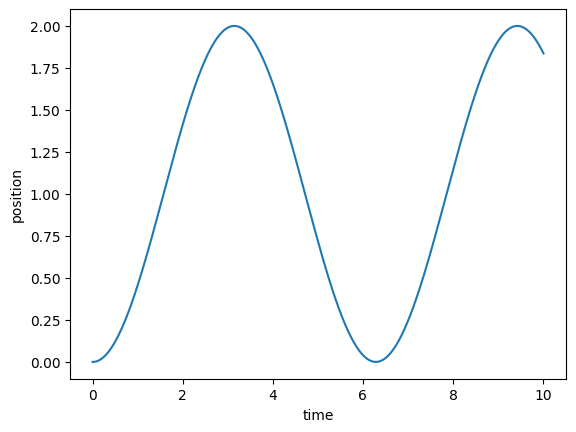

In [81]:
times = [0]
positions = [0]
delta_time = 0.01

while times[-1] < 10:
    new_position = euler(
            current_time=times[-1],
            current_y=positions[-1],
            derivative_fn=velocity,
            # velocity is the derivative of position
            delta_time=delta_time
            )
    times.append(times[-1] + delta_time)
    positions.append(new_position)

visualise_trajectory(times=times, positions=positions)

To see why Euler's method is only a numerical approximation of the actual solution, check what happens when we increase our step size ($delta\_time$):

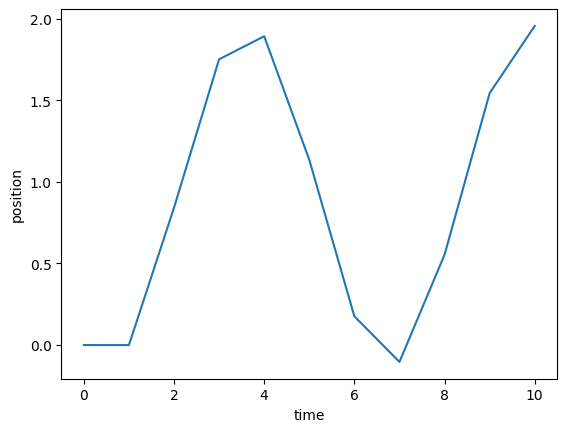

In [82]:
times = [0]
positions = [0]
delta_time = 1

while times[-1] < 10:
    new_position = euler(
            current_time=times[-1],
            current_y=positions[-1],
            derivative_fn=velocity,
            # velocity is the derivative of position
            delta_time=delta_time
            )
    times.append(times[-1] + delta_time)
    positions.append(new_position)

visualise_trajectory(times=times, positions=positions)

The approximation becomes worse! This is because we linearly approximate the slope, i.e. our slope approximation is not perfect. This approximation only remains okay if we take a small enough step in the slope's direction.
Todo: discuss error accumulation

### Runge-Kutta
Todo: get additional explanation from https://scicomp.stackexchange.com/questions/20172/why-are-runge-kutta-and-eulers-method-so-different

Runge-Kutta methods are a superset of the original Euler method that allow us to get a better slope estimate by doing more derivative function evaluations. The most widely used member of the Runge-Kutta family is the RK4 method (4 refers to 4 slope approximations via 4 derivative function evaluations).

In [83]:
def runge_kutta_4(
        current_time: float,
        current_y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope1 = derivative_fn(current_time, current_y)  # this is the original euler
    slope2 = derivative_fn(current_time + delta_time / 2, current_y + slope1 * delta_time / 2)
    slope3 = derivative_fn(current_time + delta_time / 2, current_y + slope2 * delta_time / 2)
    slope4 = derivative_fn(current_time + delta_time, current_y + slope3 * delta_time)
    average_slope = (slope1 + 2 * slope2 + 2 * slope3 + slope4) / 6
    next_y = current_y + average_slope * delta_time
    return next_y

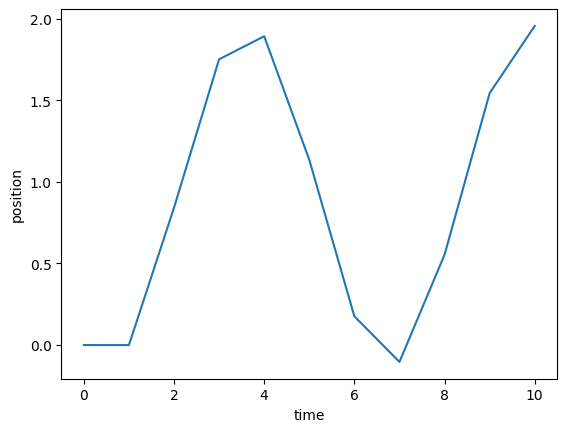

In [84]:
visualise_trajectory(times=times, positions=positions)

So RK4 is supposed to give a better results, lets validate this by comparing the euler and rk4 solutions to the exact solution.

In [85]:
exact_solution = lambda \
        times: (times, -np.cos(times) + 1)


def get_trajectory(
        solver: Callable[[float, float, Callable, float], float], ) -> Tuple[List, List]:
    times = [0]
    positions = [0]
    delta_time = 0.9

    while times[-1] < 10:
        new_position = solver(
                times[-1], positions[-1], velocity, delta_time, )
        times.append(times[-1] + delta_time)
        positions.append(new_position)
    return times, positions


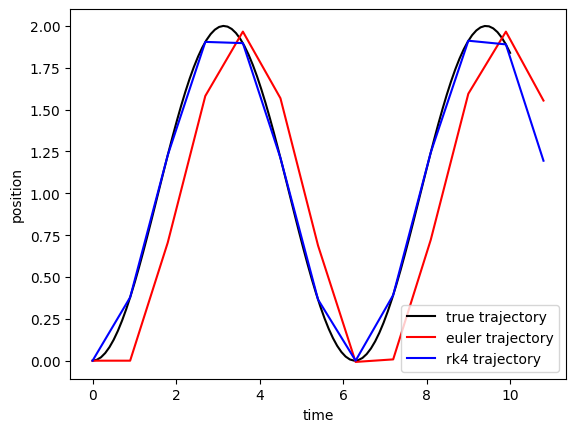

In [86]:
euler_trajectory = get_trajectory(euler)
rk4_trajectory = get_trajectory(runge_kutta_4)
true_trajectory = exact_solution(np.linspace(0, 10, 100))

plt.plot(true_trajectory[0], true_trajectory[1], label="true trajectory", color="black")
plt.plot(euler_trajectory[0], euler_trajectory[1], label="euler trajectory", color="red")
plt.plot(rk4_trajectory[0], rk4_trajectory[1], label="rk4 trajectory", color="blue")
plt.legend()
plt.xlabel("time")
plt.ylabel("position")
plt.show()
plt.close()

### Second order differential equation
The position and velocity example above is an example of a first order ODE. We used the euler and RK4 methods to solve for the position given a velocity function.
To show how we can solve second order ODEs (i.e. ODE's with a second order derivative in them), lets try to get the position of our point given a function that describes its acceleration.

We will use a constant acceleration. Given this acceleration, we can then calculate the velocity (by solving the ODE again). Given the velocity, we can then calculate the position (by again solving the ODE).

In [87]:
def acceleration(
        time: float,
        velocity: float
        ) -> float:
    return 3 * np.power(time, 2)


def get_next_velocity(
        current_time: float,
        current_velocity: float,
        acceleration_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    # take a small step
    current_acceleration = acceleration_fn(current_time, current_velocity)
    return current_velocity + current_acceleration * delta_time


def get_next_position(
        current_time: float,
        current_position: float,
        velocity_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    # take a small step
    current_velocity = velocity_fn(current_time, current_position)
    return current_position + current_velocity * delta_time

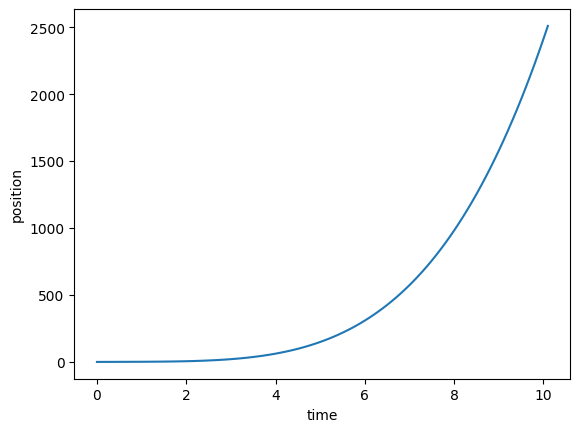

In [88]:
times = [0]
positions = [0]
velocities = [1]
delta_time = 0.1

while times[-1] < 10:
    new_velocity = get_next_velocity(
            current_time=times[-1], current_velocity=velocities[-1], acceleration_fn=acceleration, delta_time=delta_time
            )
    new_position = get_next_position(
            current_time=times[-1],
            current_position=positions[-1],
            velocity_fn=lambda
                _,
                __: velocities[-1],
            delta_time=delta_time
            )
    times.append(times[-1] + delta_time)
    positions.append(new_position)
    velocities.append(new_velocity)

visualise_trajectory(times=times, positions=positions)

Solving the second order ODE thus comes down to solving two first order ODEs. We solved $p'' = 3t^2$ with initial conditions $p(0) = 0, p'(0) = 1$.
We did this by first solving $v' = 3t^2$ with the initial condition $v(0) = 0$. This gives us $v_{t+1}$
Then we solve $p' = v_t$ with the initial condition $p(0) = 0$. In every step, we can treat $v_t$ as a constant, given that we calculated it in the previous step (or know it as an initial condition due to $p'(0)$ being given).


In a more general form, if we have a second order ODE: $y'' + y' + y = c$  with initial conditions $y(0) = a, y'(0) = b$

If we let $y_1 = y$ and $y_2 = y'$, we can write the original second order ODE as a system of two first order ODEs:
$\begin{bmatrix} y_1' \\ y_2'\end{bmatrix} = \begin{bmatrix} y_2 \\ c - y_1 - y_2\end{bmatrix}$ with initial conditions: $\begin{bmatrix} y_1(0) \\ y_2(0)\end{bmatrix} = \begin{bmatrix} a \\ b\end{bmatrix}$ 

Although indirectly, the code above uses the Euler method to solve the system of first order ODEs. We can incorporate our previous RK4 solver like this:

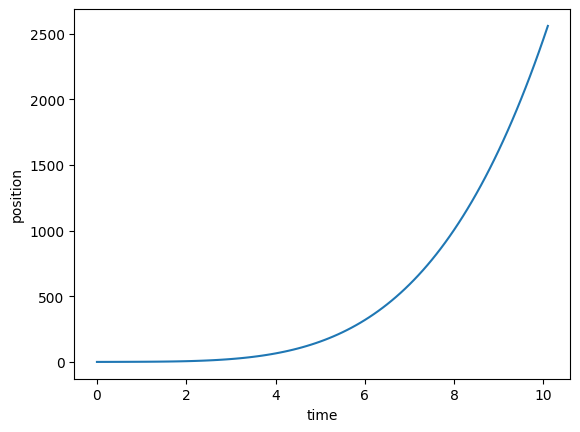

In [89]:
times = [0]
positions = [0]
velocities = [1]
delta_time = 0.1

while times[-1] < 10:
    new_velocity = runge_kutta_4(
            current_time=times[-1], current_y=velocities[-1], derivative_fn=acceleration, delta_time=delta_time
            )
    new_position = runge_kutta_4(
            current_time=times[-1],
            current_y=positions[-1],
            derivative_fn=lambda
                *_: velocities[-1],
            delta_time=delta_time
            )
    times.append(times[-1] + delta_time)
    positions.append(new_position)
    velocities.append(new_velocity)

visualise_trajectory(times=times, positions=positions)

Let's again compare our approximated solutions to the exact solution.

In [90]:
exact_solution = lambda \
        times: (times, 1 / 4 * np.power(times, 4))


def get_trajectory(
        solver: Callable[[float, float, Callable, float], float]
        ) -> Tuple[List, List]:
    times = [0]
    positions = [0]
    velocities = [0]
    delta_time = 0.5

    while times[-1] < 10:
        new_velocity = solver(
                times[-1], velocities[-1], acceleration, delta_time
                )
        new_position = solver(
                times[-1],
                positions[-1],
                lambda
                    *_: velocities[-1],
                delta_time
                )
        times.append(times[-1] + delta_time)
        positions.append(new_position)
        velocities.append(new_velocity)
    return times, positions

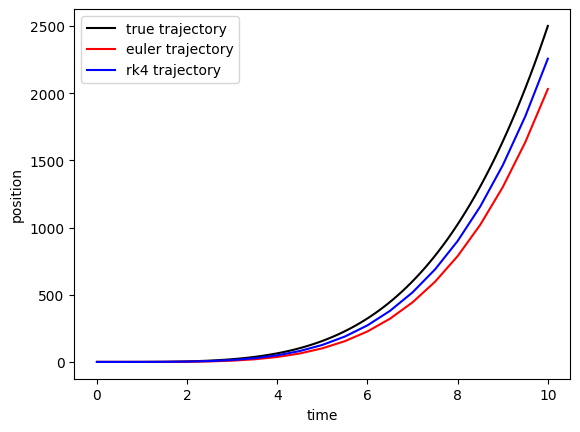

In [91]:
euler_trajectory = get_trajectory(euler)
rk4_trajectory = get_trajectory(runge_kutta_4)
true_trajectory = exact_solution(np.linspace(0, 10, 100))

plt.plot(true_trajectory[0], true_trajectory[1], label="true trajectory", color="black")
plt.plot(euler_trajectory[0], euler_trajectory[1], label="euler trajectory", color="red")
plt.plot(rk4_trajectory[0], rk4_trajectory[1], label="rk4 trajectory", color="blue")
plt.legend()
plt.xlabel("time")
plt.ylabel("position")
plt.show()
plt.close()

In the same way that a second order ODE can be decomposed into a system of two first order ODEs, we can do the same for even higher order ODEs


## Solving a CPG's ODEs

After this sidestep, we now know how to solve ODEs. So let us solve the ODEs of a CPG like the one in the Sproewitz paper:

$\dot{\phi_i} = \omega_i + \sum_j{w_{ij}r_j}\sin{(\phi_j - \phi_i - \rho_{ij})}$<br>
$\ddot{r_i} = a_r(\frac{a_r}{4}(R_i - r_i) - \dot{r_i})$<br>
$\ddot{x_i} = a_x(\frac{a_x}{4}(X_i - x_i) - \dot{x_i})$<br>
$\theta_i = x_i + r_i\cos{(\phi_i)}$<br>

We will do so for a CPG with two bidirectionally connected neurons.
Todo: add image

In [166]:
# Constants
amplitude_gain = 20
offset_gain = 20
adjacency_matrix = jnp.array(
        [[0, 1], [1, 0]]
        )

# Modulation parameters
omegas = (jnp.pi / 2) * jnp.array([1.0, 1.0])
R = jnp.array([1.0, 0.5])
X = jnp.array([1.0, -1.0])

# Normally we optimize the weights, phase biases can be optimized or used as a modulation
weights = adjacency_matrix * 5
phase_biases = adjacency_matrix * jnp.array([[2 * jnp.pi / 5], [-2 * jnp.pi / 5]])

In [167]:
def phase_ode(
        omegas: jnp.ndarray,
        weights: jnp.ndarray,
        amplitudes: jnp.ndarray,
        phases: jnp.ndarray,
        phase_biases: jnp.ndarray
        ) -> jnp.ndarray:

    @jax.vmap
    def sine_term(
            phase_i: float,
            phase_biases_i: float
            ) -> jnp.ndarray:
        return jnp.sin(phases - phase_i - phase_biases_i)

    couplings = jnp.sum(weights * amplitudes * sine_term(phases, phase_biases), axis=1)
    return omegas + couplings


In [168]:
def second_order_ode(
        gain: jnp.ndarray,
        modulator: jnp.ndarray,
        values: jnp.ndarray,
        d_values: jnp.ndarray
        ) -> jnp.ndarray:
    return gain * ((gain / 4) * (modulator - values) - d_values)


def first_order_ode(
        d_values: jnp.ndarray
        ) -> jnp.ndarray:
    return d_values

In [169]:
def output(
        offsets: jnp.ndarray,
        amplitudes: jnp.ndarray,
        phases: jnp.ndarray
        ) -> jnp.ndarray:
    return offsets + amplitudes * jnp.cos(phases)

In [170]:
@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    d_amplitudes: jnp.ndarray
    amplitudes: jnp.ndarray
    d_offsets: jnp.ndarray
    offsets: jnp.ndarray
    outputs: jnp.ndarray

In [222]:
# Derivative fn expects (time, y)
def step_cpg(
        delta_time: float,
        state: CPGState,
        solver: Callable
        ) -> CPGState:
    # Update phase
    new_phases = solver(
            current_time=state.time,
            # invariant of time
            current_y=state.phases,
            derivative_fn=lambda
                t,
                y: phase_ode(
                    omegas=omegas, weights=weights, amplitudes=state.amplitudes, phases=y, phase_biases=phase_biases
                    ),
            delta_time=delta_time
            )
    new_d_amplitudes = solver(
            current_time=state.time,
            current_y=state.d_amplitudes,
            derivative_fn=lambda
                t,
                y: second_order_ode(gain=amplitude_gain, modulator=R, values=state.amplitudes, d_values=y),
            delta_time=delta_time
            )
    new_amplitudes = solver(
            current_time=state.time,
            current_y=state.amplitudes,
            derivative_fn=lambda
                t,
                y: first_order_ode(d_values=state.d_amplitudes),
            delta_time=delta_time
            )
    new_d_offsets = solver(
            current_time=0,
            current_y=state.d_offsets,
            derivative_fn=lambda
                t,
                y: second_order_ode(gain=offset_gain, modulator=X, values=state.offsets, d_values=y),
            delta_time=delta_time
            )
    new_offsets = solver(
            current_time=0,
            current_y=state.offsets,
            derivative_fn=lambda
                t,
                y: first_order_ode(d_values=state.d_offsets),
            delta_time=delta_time
            )

    new_outputs = output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
    return state.replace(
            phases=new_phases,
            d_amplitudes=new_d_amplitudes,
            amplitudes=new_amplitudes,
            d_offsets=new_d_offsets,
            offsets=new_offsets,
            outputs=new_outputs,
            time=state.time + delta_time
            )

In [223]:
# Initial conditions
def get_initial_state() -> CPGState:
    state = CPGState(
            phases=jnp.zeros(adjacency_matrix.shape[0]),
            amplitudes=jnp.zeros(adjacency_matrix.shape[0]),
            d_amplitudes=jnp.zeros(adjacency_matrix.shape[0]),
            offsets=jnp.zeros(adjacency_matrix.shape[0]),
            d_offsets=jnp.zeros(adjacency_matrix.shape[0]),
            time=0.0,
            outputs=jnp.zeros(adjacency_matrix.shape[0])
            )
    return state

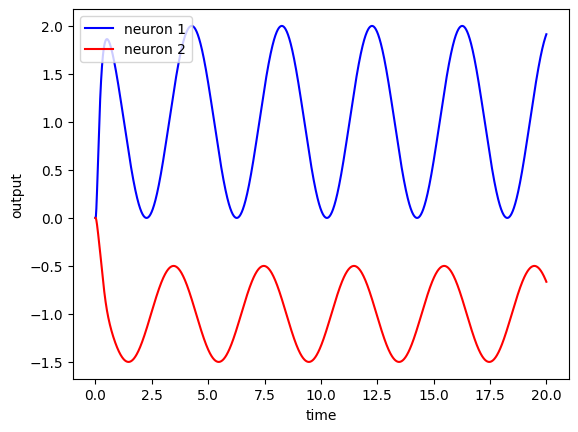

In [226]:
dt = 0.01
states = [get_initial_state()]
jit_step = jax.jit(functools.partial(step_cpg, solver=runge_kutta_4))
while states[-1].time < 20:
    state = jit_step(
            delta_time=dt, state=states[-1]
            )
    states.append(state)

times = [state.time for state in states]
o1 = [state.outputs[0] for state in states]
o2 = [state.outputs[1] for state in states]
plt.plot(times, o1, color="blue", label="neuron 1")
plt.plot(times, o2, color="red", label="neuron 2")
plt.legend()
plt.xlabel("time")
plt.ylabel("output")
plt.show()
plt.close() 

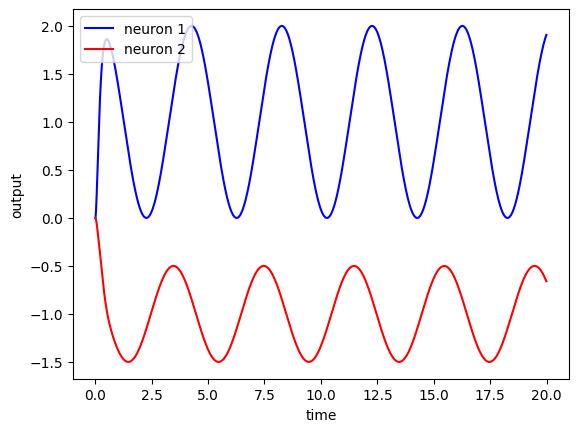

In [228]:
# jax.lax.scan version
def do_n_cpg_steps(
        state: CPGState,
        num_steps: int
        ) -> List[CPGState]:
    def f(
            s,
            _
            ) -> Tuple[CPGState, CPGState]:
        s = jit_step(
                delta_time=dt, state=s
                )
        return s, s

    _, states = jax.lax.scan(f=f, init=state, xs=(), length=num_steps)
    return states
state = get_initial_state()
state = do_n_cpg_steps(state=state, num_steps=20 // dt)

times = state.time
o1 = state.outputs[:, 0]
o2 = state.outputs[:, 1] 
plt.plot(times, o1, color="blue", label="neuron 1")
plt.plot(times, o2, color="red", label="neuron 2")
plt.legend()
plt.xlabel("time")
plt.ylabel("output")
plt.show()
plt.close() 
# visualise_cpg_trajectory([state] + states)

TODO: show that we can use random initial conditions
TODO: show that we can do an abrupt change of Ri, offset and phase lag parameters (as in sproewitz)

## Applying a CPG to the toy example environment

1. Create a controller CPG
2. Do rollout
3. Visualise

## References

